# 参考

## encoder
> 来源: https://github.com/vietanhdev/samexporter

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from typing import List

from segment_anything.modeling import Sam


class ImageEncoderOnnxModel(nn.Module):
    """
    if preprocess==true:
        (h,w,c)每个通道分别标准化
        转为(c,h,w)
        图像填充至(c,1024,1024)
        转为(1,c,1024,1024)
    forward:
        调用sam.image_encoder后输出(1,256,64,64)
    """

    DEFAULT_PIXEL_MEAN = [123.675, 116.28, 103.53]
    DEFAULT_PIXEL_STD = [58.395, 57.12, 57.375]

    def __init__(
        self,
        model: Sam,
        use_preprocess: bool,
        pixel_mean: List[float] = None,
        pixel_std: List[float] = None,
    ):
        if pixel_mean is None:
            pixel_mean = self.DEFAULT_PIXEL_MEAN
        if pixel_std is None:
            pixel_std = self.DEFAULT_PIXEL_STD

        super().__init__()
        self.use_preprocess = use_preprocess
        self.pixel_mean = torch.tensor(pixel_mean, dtype=torch.float)
        self.pixel_std = torch.tensor(pixel_std, dtype=torch.float)
        self.image_encoder = model.image_encoder

    @torch.no_grad()
    def forward(self, input_image: torch.Tensor):
        if self.use_preprocess:
            input_image = self.preprocess(input_image)
        image_embeddings = self.image_encoder(input_image)
        return image_embeddings

    def preprocess(self, x: torch.Tensor) -> torch.Tensor:
        # Normalize colors
        x = (x - self.pixel_mean) / self.pixel_std

        # permute channels
        x = torch.permute(x, (2, 0, 1))

        # Pad
        h, w = x.shape[-2:]
        padh = self.image_encoder.img_size - h
        padw = self.image_encoder.img_size - w
        x = F.pad(x, (0, padw, 0, padh))

        # expand channels
        x = torch.unsqueeze(x, 0)
        return x


删减mobile部分

In [31]:
import torch
import onnx

from segment_anything import sam_model_registry
#from samexporter.mobile_encoder.setup_mobile_sam import setup_model
#from samexporter.onnx_utils import ImageEncoderOnnxModel
from onnx.external_data_helper import convert_model_to_external_data

import os
from tempfile import mkdtemp
import pathlib
import shutil
import argparse
import warnings
def run_export_encoder(
    model_type: str,
    checkpoint: str,
    output: str,
    use_preprocess: bool,
    opset: int,
    gelu_approximate: bool = False,
):
    print("Loading model...")
    if model_type == "mobile":
        # checkpoint = torch.load(checkpoint, map_location="cpu")
        # sam = setup_model()
        # sam.load_state_dict(checkpoint, strict=True)
        pass  
    else:
        sam = sam_model_registry[model_type](checkpoint=checkpoint)

    onnx_model = ImageEncoderOnnxModel(
        model=sam,
        use_preprocess=use_preprocess,
        pixel_mean=[123.675, 116.28, 103.53],
        pixel_std=[58.395, 57.12, 57.375],
    )

    if gelu_approximate:
        for _, m in onnx_model.named_modules():
            if isinstance(m, torch.nn.GELU):
                m.approximate = "tanh"

    image_size = sam.image_encoder.img_size
    if use_preprocess:
        dummy_input = {
            "input_image": torch.randn(
                (image_size, image_size, 3), dtype=torch.float
            )
        }
        dynamic_axes = {
            "input_image": {0: "image_height", 1: "image_width"},
        }
    else:
        dummy_input = {
            "input_image": torch.randn(
                (1, 3, image_size, image_size), dtype=torch.float
            )
        }
        dynamic_axes = None

    _ = onnx_model(**dummy_input)

    output_names = ["image_embeddings"]

    onnx_base = os.path.splitext(os.path.basename(output))[0]
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        print(f"Exporting onnx model to {output}...")
        if model_type == "vit_h":
            tmp_dir = mkdtemp()
            tmp_model_path = os.path.join(tmp_dir, f"{onnx_base}.onnx")
            torch.onnx.export(
                onnx_model,
                tuple(dummy_input.values()),
                tmp_model_path,
                export_params=True,
                verbose=False,
                opset_version=opset,
                do_constant_folding=True,
                input_names=list(dummy_input.keys()),
                output_names=output_names,
                dynamic_axes=dynamic_axes,
            )

            # Combine the weights into a single file
            pathlib.Path(output).parent.mkdir(parents=True, exist_ok=True)
            onnx_model = onnx.load(tmp_model_path)
            convert_model_to_external_data(
                onnx_model,
                all_tensors_to_one_file=True,
                location=f"{onnx_base}_data.bin",
                size_threshold=1024,
                convert_attribute=False,
            )

            # Save the model
            onnx.save(onnx_model, output)

            # Cleanup the temporary directory
            shutil.rmtree(tmp_dir)
        else:
            with open(output, "wb") as f:
                torch.onnx.export(
                    onnx_model,
                    tuple(dummy_input.values()),
                    f,
                    export_params=True,
                    verbose=False,
                    opset_version=opset,
                    do_constant_folding=True,
                    input_names=list(dummy_input.keys()),
                    output_names=output_names,
                    dynamic_axes=dynamic_axes,
                )



## decoder
> 来源: https://github.com/vietanhdev/samexporter
> 来源: https://github.com/facebookresearch/segment-anything

In [4]:
import pathlib

import torch

from segment_anything import sam_model_registry
from segment_anything.utils.onnx import SamOnnxModel

import argparse
import warnings

try:
    import onnxruntime  # type: ignore

    onnxruntime_exists = True
except ImportError:
    onnxruntime_exists = False

def to_numpy(tensor):
    return tensor.cpu().numpy()

def run_export_decoder(
    model_type: str,
    checkpoint: str,
    output: str,
    opset: int,
    return_single_mask: bool,
    gelu_approximate: bool = False,
    use_stability_score: bool = False,
    return_extra_metrics=False,
):
    print("Loading model...")
    sam = sam_model_registry[model_type](checkpoint=checkpoint)

    onnx_model = SamOnnxModel(
        model=sam,
        return_single_mask=return_single_mask,
        use_stability_score=use_stability_score,
        return_extra_metrics=return_extra_metrics,
    )

    if gelu_approximate:
        for _, m in onnx_model.named_modules():
            if isinstance(m, torch.nn.GELU):
                m.approximate = "tanh"

    dynamic_axes = {
        "point_coords": {1: "num_points"},
        "point_labels": {1: "num_points"},
    }

    embed_dim = sam.prompt_encoder.embed_dim
    embed_size = sam.prompt_encoder.image_embedding_size
    mask_input_size = [4 * x for x in embed_size]
    dummy_inputs = {
        "image_embeddings": torch.randn(
            1, embed_dim, *embed_size, dtype=torch.float
        ),
        "point_coords": torch.randint(
            low=0, high=1024, size=(1, 5, 2), dtype=torch.float
        ),
        "point_labels": torch.randint(
            low=0, high=4, size=(1, 5), dtype=torch.float
        ),
        "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
        "has_mask_input": torch.tensor([1], dtype=torch.float),
        "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
    }

    _ = onnx_model(**dummy_inputs)

    output_names = ["masks", "iou_predictions", "low_res_masks"]

    pathlib.Path(output).parent.mkdir(parents=True, exist_ok=True)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        with open(output, "wb") as f:
            print(f"Exporting onnx model to {output}...")
            torch.onnx.export(
                onnx_model,
                tuple(dummy_inputs.values()),
                f,
                export_params=True,
                verbose=False,
                opset_version=opset,
                do_constant_folding=True,
                input_names=list(dummy_inputs.keys()),
                output_names=output_names,
                dynamic_axes=dynamic_axes,
            )

    if onnxruntime_exists:
        ort_inputs = {k: to_numpy(v) for k, v in dummy_inputs.items()}
        # set cpu provider default
        providers = ["CPUExecutionProvider"]
        ort_session = onnxruntime.InferenceSession(output, providers=providers)
        _ = ort_session.run(None, ort_inputs)
        print("Model has successfully been run with ONNXRuntime.")

## example
导出encoder.onnx和decoder.onnx,并在python中调用

### 导出encoder.onnx和decoder.onnx

In [6]:
checkpoint = "../sam_vit_b_01ec64.pth"
model_type = "vit_b"

run_export_encoder(
    model_type=model_type,
    checkpoint=checkpoint,
    output="sam_vit_b_encoder.onnx",
    use_preprocess=True,
    opset=17,
)
run_export_decoder(
    model_type=model_type,
    checkpoint=checkpoint,
    output="sam_vit_b_decoder.onnx",
    opset=17,
    return_single_mask=True,
)

Loading model...
Exporting onnx model to sam_vit_b_encoder.onnx...
Loading model...
Exporting onnx model to sam_vit_b_decoder.onnx...
Model has successfully been run with ONNXRuntime.


### 在python中调用

In [ ]:

import logging

logging.basicConfig(level=logging.DEBUG)

from copy import deepcopy

import cv2
import numpy as np
import onnxruntime


class SegmentAnythingONNX:
    """Segmentation model using Segment Anything (SAM)"""

    def __init__(self, encoder_model_path, decoder_model_path) -> None:
        self.target_size = 1024
        self.input_size = (684, 1024)

        # Load models
        providers = onnxruntime.get_available_providers()

        # Pop TensorRT Runtime due to crashing issues
        # TODO: Add back when TensorRT backend is stable
        providers = [p for p in providers if p != "TensorrtExecutionProvider"]

        if providers:
            logging.info(
                "Available providers for ONNXRuntime: %s", ", ".join(providers)
            )
        else:
            logging.warning("No available providers for ONNXRuntime")
        self.encoder_session = onnxruntime.InferenceSession(
            encoder_model_path, providers=providers
        )
        self.encoder_input_name = self.encoder_session.get_inputs()[0].name
        self.decoder_session = onnxruntime.InferenceSession(
            decoder_model_path, providers=providers
        )

    def get_input_points(self, prompt):
        """Get input points"""
        points = []
        labels = []
        for mark in prompt:
            if mark["type"] == "point":
                points.append(mark["data"])
                labels.append(mark["label"])
            elif mark["type"] == "rectangle":
                points.append([mark["data"][0], mark["data"][1]])  # top left
                points.append(
                    [mark["data"][2], mark["data"][3]]
                )  # bottom right
                labels.append(2)
                labels.append(3)
        points, labels = np.array(points), np.array(labels)
        return points, labels

    def run_encoder(self, encoder_inputs):
        """Run encoder"""
        output = self.encoder_session.run(None, encoder_inputs)
        image_embedding = output[0]
        return image_embedding

    @staticmethod
    def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int):
        """
        Compute the output size given input size and target long side length.
        """
        scale = long_side_length * 1.0 / max(oldh, oldw)
        newh, neww = oldh * scale, oldw * scale
        neww = int(neww + 0.5)
        newh = int(newh + 0.5)
        return (newh, neww)

    def apply_coords(self, coords: np.ndarray, original_size, target_length):
        """
        Expects a numpy array of length 2 in the final dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], target_length
        )
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def run_decoder(
        self, image_embedding, original_size, transform_matrix, prompt
    ):
        """
        point/rect的坐标转为(N,2),label转为(N,1)
            其中rect的coord是(2,2),label是(2,1),label的值规定为tl=2,br=3
            其中point的coord是(1,2),label是(1,1),label的值规定为true=1,false=0
        坐标转为resize后的坐标,因为pad是右侧和下侧填充,所以不需要考虑平移(resize尺寸(1024,1024))
        point/rect末尾添加一行coord=[0,0],label=[-1] #why?
        decoder输入:
            img_embedding(1,256,64,64)
            coord转为(1,N,2)
            label转为(1,N,1)
            maskinput固定zeros(1,1,256,256)
            hasMaskInput固定zeros(1)
            orig_im_size固定为(684,1024)
        decoder输出:
            mask
        mask转为原图尺寸
        """
        input_points, input_labels = self.get_input_points(prompt)
    
        # Add a batch index, concatenate a padding point, and transform.
        # onnx_coord = np.concatenate(
        #     [input_points, np.array([[0.0, 0.0]])], axis=0
        # )[None, :, :]
        # onnx_label = np.concatenate([input_labels, np.array([-1])], axis=0)[
        #     None, :
        # ].astype(np.float32)

        onnx_coord = np.concatenate(
            [input_points], axis=0
        )[None, :, :]
        onnx_label = np.concatenate([input_labels], axis=0)[
            None, :
        ].astype(np.float32)


        #input_size=(684,1024),target_size=1024.完全没用处
        onnx_coord = self.apply_coords(
            onnx_coord, self.input_size, self.target_size
        ).astype(np.float32)

        # Apply the transformation matrix to the coordinates.
        onnx_coord = np.concatenate(
            [
                onnx_coord,
                np.ones((1, onnx_coord.shape[1], 1), dtype=np.float32),
            ],
            axis=2,
        )
        onnx_coord = np.matmul(onnx_coord, transform_matrix.T)
        onnx_coord = onnx_coord[:, :, :2].astype(np.float32)

        # Create an empty mask input and an indicator for no mask.
        onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
        onnx_has_mask_input = np.zeros(1, dtype=np.float32)

        decoder_inputs = {
            "image_embeddings": image_embedding,
            "point_coords": onnx_coord,
            "point_labels": onnx_label,
            "mask_input": onnx_mask_input,
            "has_mask_input": onnx_has_mask_input,
            "orig_im_size": np.array(self.input_size, dtype=np.float32), 
        }

        masks, _, _ = self.decoder_session.run(None, decoder_inputs)
        # Transform the masks back to the original image size.
        inv_transform_matrix = np.linalg.inv(transform_matrix)
        transformed_masks = self.transform_masks(
            masks, original_size, inv_transform_matrix
        )
        return transformed_masks

    def transform_masks(self, masks, original_size, transform_matrix):
        """Transform the masks back to the original image size."""
        output_masks = []
        for batch in range(masks.shape[0]):
            batch_masks = []
            for mask_id in range(masks.shape[1]):
                mask = masks[batch, mask_id]
                mask = cv2.warpAffine(
                    mask,
                    transform_matrix[:2],
                    (original_size[1], original_size[0]),
                    flags=cv2.INTER_LINEAR,
                )
                batch_masks.append(mask)
            output_masks.append(batch_masks)
        return np.array(output_masks)
    
    def encode(self, cv_image):
        """
        cv_image(h,w,c)缩放至(newh,neww,c),其中max(newh,neww)=1024,输入至encoder
         return {
            "image_embedding": image_embedding,
            "original_size": original_size,
            "transform_matrix": transform_matrix,
        }
        注:warpaffine后第684行都是0,merge中改为transform.Resize
        """
        original_size = cv_image.shape[:2]

        # Calculate a transformation matrix to convert to self.input_size
        scale_x = self.input_size[1] / cv_image.shape[1]
        scale_y = self.input_size[0] / cv_image.shape[0]
        scale = min(scale_x, scale_y)
        transform_matrix = np.array(
            [
                [scale, 0, 0],
                [0, scale, 0],
                [0, 0, 1],
            ]
        )
        cv_image = cv2.warpAffine(
            cv_image,
            transform_matrix[:2],
            (self.input_size[1], self.input_size[0]),
            flags=cv2.INTER_LINEAR,
        )

        encoder_inputs = {
            self.encoder_input_name: cv_image.astype(np.float32),
        }
        
        image_embedding = self.run_encoder(encoder_inputs)
        #image_embedding=torch.zeros((1, 256, 64, 64),dtype=torch.float32)
        return {
            "image_embedding": image_embedding,
            "original_size": original_size,
            "transform_matrix": transform_matrix,
        }

    def predict_masks(self, embedding, prompt):
        """
        Predict masks for a single image.
        """
        masks = self.run_decoder(
            embedding["image_embedding"],
            embedding["original_size"],
            embedding["transform_matrix"],
            prompt,
        )

        return masks


#### 调用

In [ ]:
import matplotlib.pyplot as plt

model = SegmentAnythingONNX(
    encoder_model_path="sam_vit_b_encoder.onnx",
    decoder_model_path="sam_vit_b_decoder.onnx",
    )

image = cv2.imread("images/truck.jpg")

embedding = model.encode(image)

prompt=[
    {"type": "point", "data": [575, 750], "label": 0},
    {"type": "rectangle", "data": [425, 600, 700, 875]}
]
masks = model.predict_masks(embedding, prompt) #masks.shape: (1, 1, 1200, 1800)


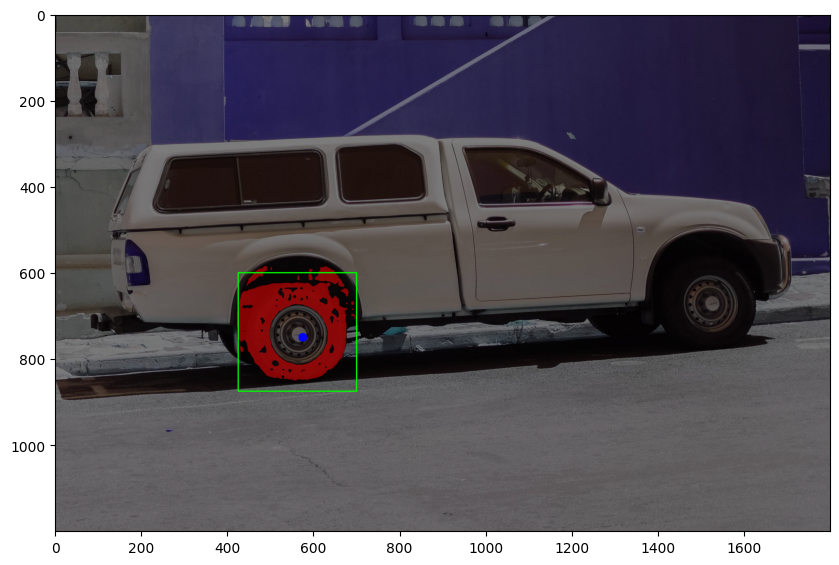

In [62]:
# Merge masks
mask = np.zeros((masks.shape[2], masks.shape[3], 3), dtype=np.uint8)
for m in masks[0, :, :, :]:
    mask[m > 0.5] = [255, 0, 0]

# Binding image and mask
visualized = cv2.addWeighted(image, 0.5, mask, 0.5, 0)

# Draw the prompt points and rectangles.
for p in prompt:
    if p["type"] == "point":
        color = (
            (0, 255, 0) if p["label"] == 1 else (0, 0, 255)
        )  # green for positive, red for negative
        cv2.circle(visualized, (p["data"][0], p["data"][1]), 10, color, -1)
    elif p["type"] == "rectangle":
        cv2.rectangle(
            visualized,
            (p["data"][0], p["data"][1]),
            (p["data"][2], p["data"][3]),
            (0, 255, 0),
            2,
        )

plt.figure(figsize=(10,10))
plt.imshow(visualized)

INFO:root:Available providers for ONNXRuntime: AzureExecutionProvider, CPUExecutionProvider


masks.shape:  (1, 1, 684, 1024)


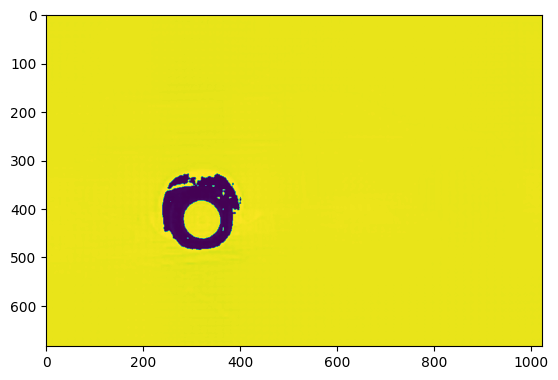

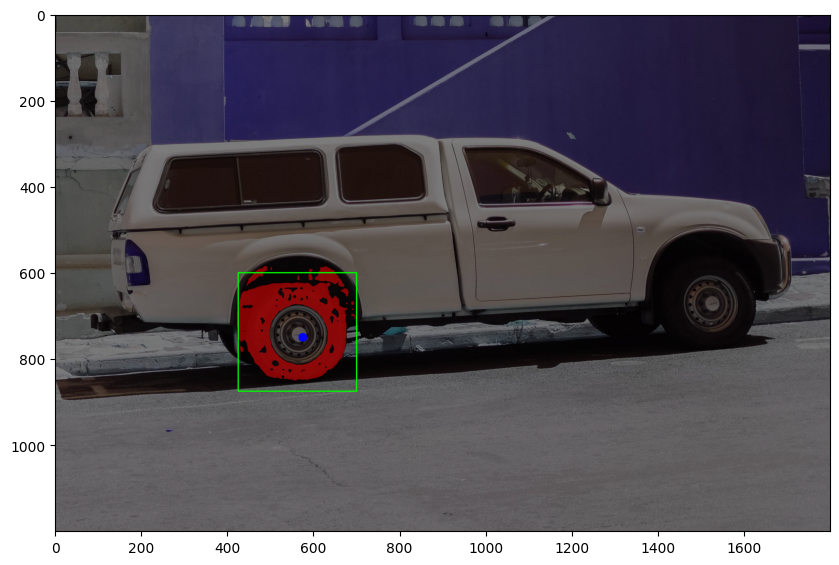

In [3]:
import matplotlib.pyplot as plt

model = SegmentAnythingONNX(
    encoder_model_path="sam_vit_b_encoder.onnx",
    decoder_model_path="sam_vit_b_decoder.onnx",
    )

image = cv2.imread("images/truck.jpg")

embedding = model.encode(image)

prompt=[
    {"type": "point", "data": [575, 750], "label": 0},
    {"type": "rectangle", "data": [425, 600, 700, 875]}
]
masks = model.predict_masks(embedding, prompt) #masks.shape: (1, 1, 1200, 1800)

# Merge masks
mask = np.zeros((masks.shape[2], masks.shape[3], 3), dtype=np.uint8)
for m in masks[0, :, :, :]:
    mask[m > 0.5] = [255, 0, 0]

# Binding image and mask
visualized = cv2.addWeighted(image, 0.5, mask, 0.5, 0)

# Draw the prompt points and rectangles.
for p in prompt:
    if p["type"] == "point":
        color = (
            (0, 255, 0) if p["label"] == 1 else (0, 0, 255)
        )  # green for positive, red for negative
        cv2.circle(visualized, (p["data"][0], p["data"][1]), 10, color, -1)
    elif p["type"] == "rectangle":
        cv2.rectangle(
            visualized,
            (p["data"][0], p["data"][1]),
            (p["data"][2], p["data"][3]),
            (0, 255, 0),
            2,
        )

plt.figure(figsize=(10,10))
plt.imshow(visualized)

# merge
samexporter将encoder和decoder分为两个onnx model,和图像缩放/还原等处理放在SegmentAnythingONNX中,c++调用还得重新实现SegmentAnythingONNX,和只能标记一个目标
改为一个onnx model,简化调用
    输入: 任意尺寸图像,point/rect和它的label
    输出: 输入图像尺寸的mask,


### 自定义onnxmodel

In [127]:
import torch
import torch.nn as nn
import numpy as np
import cv2
from torch.nn import functional as F
from torchvision.transforms.functional import resize

from typing import List
from typing import Tuple

from segment_anything.modeling import Sam
from segment_anything.utils.onnx import SamOnnxModel

class SamMergeOnnxModel(nn.Module):
    DEFAULT_PIXEL_MEAN = [123.675, 116.28, 103.53]
    DEFAULT_PIXEL_STD = [58.395, 57.12, 57.375]
    def __init__(
        self,
        model: Sam,
        pixel_mean: List[float] = None,
        pixel_std: List[float] = None,
    ):
        if pixel_mean is None:
            pixel_mean = self.DEFAULT_PIXEL_MEAN
        if pixel_std is None:
            pixel_std = self.DEFAULT_PIXEL_STD

        super().__init__()
        self.pixel_mean = torch.tensor(pixel_mean, dtype=torch.float).view(3, 1, 1)
        self.pixel_std = torch.tensor(pixel_std, dtype=torch.float).view(3, 1, 1)
        self.image_encoder = model.image_encoder
        self.model=model
        self.input_size = (1024,1024)
        self.img_size = model.image_encoder.img_size

    def preprocess_normalize_padding_expandDims(self, x: torch.Tensor) -> torch.Tensor:
        # Normalize colors
        x = (x - self.pixel_mean) / self.pixel_std
        # Pad
        h, w = x.shape[-2:]
        padh = self.image_encoder.img_size - h
        padw = self.image_encoder.img_size - w
        x = F.pad(x, (0, padw, 0, padh))

        # expand channels
        x = torch.unsqueeze(x, 0)
        return x

    
    def preprocess_resize(self, x: torch.Tensor):
        """
        Tensor(3,h,w)转为长边=1024
        """
        long_side_length = self.input_size[0]  # 1024
        oldh,oldw= x.shape[-2:]
        max_side_length = oldh if oldh > oldw else oldw
        #scale = long_side_length * 1.0 / max(oldh, oldw) #why: onnxmodel计算max()结果错误: max(1200,1800)=1200
        scale = long_side_length * 1.0 / max_side_length
        newh, neww = oldh * scale, oldw * scale
        neww = int(neww + 0.5)
        newh = int(newh + 0.5)
        '''
        ONNX 不支持直接导出包含 torchvision.transforms.functional.resize 的模型，因为它不是一个原生的 PyTorch 操作。
        '''
        # 使用 F.interpolate 替代 resize
        x = x.unsqueeze(0)  # 添加批次维度 (1, C, H, W)
        x = F.interpolate(x, size=(683, 1024), mode="bilinear", align_corners=False)
        x = x.squeeze(0)  # 移除批次维度 (C, H, W)
        return x, scale
         
    
    def _embed_points(self, point_coords: torch.Tensor, point_labels: torch.Tensor) -> torch.Tensor:
        point_coords = point_coords + 0.5
        point_coords = point_coords / self.img_size
        point_embedding = self.model.prompt_encoder.pe_layer._pe_encoding(point_coords)
        point_labels = point_labels.unsqueeze(-1).expand_as(point_embedding)

        point_embedding = point_embedding * (point_labels != -1)
        point_embedding = point_embedding + self.model.prompt_encoder.not_a_point_embed.weight * (
            point_labels == -1
        )

        for i in range(self.model.prompt_encoder.num_point_embeddings):
            point_embedding = point_embedding + self.model.prompt_encoder.point_embeddings[
                i
            ].weight * (point_labels == i)

        return point_embedding

    def _embed_masks(self, input_mask: torch.Tensor, has_mask_input: torch.Tensor) -> torch.Tensor:
        mask_embedding = has_mask_input * self.model.prompt_encoder.mask_downscaling(input_mask)
        mask_embedding = mask_embedding + (
            1 - has_mask_input
        ) * self.model.prompt_encoder.no_mask_embed.weight.reshape(1, -1, 1, 1)
        return mask_embedding

    def select_masks(
        self, masks: torch.Tensor, iou_preds: torch.Tensor, num_points: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # Determine if we should return the multiclick mask or not from the number of points.
        # The reweighting is used to avoid control flow.
        score_reweight = torch.tensor(
            [[1000] + [0] * (self.model.mask_decoder.num_mask_tokens - 1)]
        ).to(iou_preds.device)
        score = iou_preds + (num_points - 2.5) * score_reweight
        best_idx = torch.argmax(score, dim=1)
        masks = masks[torch.arange(masks.shape[0]), best_idx, :, :].unsqueeze(1)
        iou_preds = iou_preds[torch.arange(masks.shape[0]), best_idx].unsqueeze(1)

        return masks, iou_preds
    
    def postprocess_mask(self,masks,orig_im_size):
        masks = F.interpolate(
            masks,
            size=self.input_size,
            mode="bilinear",
            align_corners=False,
        )
        prepadded_masks = F.interpolate(
            masks,
            size=(self.input_size[0], self.input_size[1]),
            mode="bilinear",
            align_corners=False,
        )
        return masks

    @torch.no_grad()
    def forward(
        self,
        input_image: torch.Tensor,
        point_coords: torch.Tensor,
        point_labels: torch.Tensor,
        #mask_input: torch.Tensor, 
        #has_mask_input: torch.Tensor,
        ):
        '''
        输入:
            图像(3,h,w)
            point:(N,2)
            label:(N,1)
        '''
        '''
        当input_image有动态尺寸时,onnx输出resize和pad尺寸可能与预期不符,这里增加image_resize,image_pad来显式指定
        '''
        #图像缩放 
        original_size=input_image.shape[-2:]
        image_resize,scale= self.preprocess_resize(input_image)
        prepadded_size=image_resize.shape[-2:]
        #图像标准化+填充0至(c,1024,1024)并转为(1,c,1024,1024)
        image_1024_1024= self.preprocess_normalize_padding_expandDims(image_resize)
        #图像转(1,256,64,64)的embedding
        image_embeddings = self.model.image_encoder(image_1024_1024)
        #image_embeddings=torch.zeros((1,256,64,64),dtype=torch.float32)
        #point坐标和mask缩放
        point_coords=point_coords*scale
        onnx_mask_input = torch.zeros((1, 1, 256, 256), dtype=torch.float32) #todo: 增加mask
        onnx_has_mask_input = torch.zeros(1, dtype=torch.float32)
        #point和label转为(1,N,2),(1,N)
        point_coords=point_coords.unsqueeze(0)
        point_labels=point_labels.unsqueeze(0)


        # onnx_model=SamOnnxModel(
        #     model=self.model,
        #     return_single_mask=True,
        # )
        # onnx_masks,scores,_= onnx_model.forward(
        #     image_embeddings=image_embeddings,
        #     point_coords=point_coords,
        #     point_labels=point_labels,
        #     mask_input=onnx_mask_input,
        #     has_mask_input=onnx_has_mask_input,
        #     orig_im_size=torch.tensor(prepadded_size, dtype=torch.float32),
        # )
        # #print("masks.shape: ", onnx_masks.shape)   
        # #plt.imshow(onnx_masks[0, 0].cpu().numpy().astype(np.uint8))
        # return onnx_masks,scores

        #point和mask转embedding
        sparse_embeddings = self._embed_points(point_coords, point_labels)
        dense_embeddings = self._embed_masks(onnx_mask_input, onnx_has_mask_input)

        masks,scores=self.model.mask_decoder.predict_masks(
            image_embeddings=image_embeddings,
            image_pe=self.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
        )

        masks, scores = self.select_masks(
            masks=masks,
            iou_preds=scores,
            num_points=point_coords.shape[1],
        )
        #将masks缩放至(1024,1024)
        masks = F.interpolate(
            masks,
            size=(1024,1024),
            mode="bilinear",
            align_corners=False,
        )
        #masks取非pad部分
        masks = masks[...,:prepadded_size[0], :prepadded_size[1]]
        #masks转为原图大小
        masks = F.interpolate(
            masks,
            size=original_size,
            mode="bilinear",
            align_corners=False,
        )

        return masks,scores

### 直接调用onnxmodel

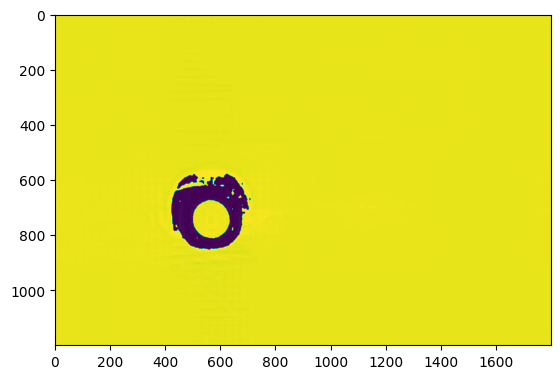

In [133]:
from segment_anything import sam_model_registry
cv2_image = cv2.imread("images/truck.jpg")

cv2_image_tensor = torch.from_numpy(cv2_image).permute(2, 0, 1).float()
mergeModel=SamMergeOnnxModel(
    model=sam_model_registry["vit_b"](checkpoint="../sam_vit_b_01ec64.pth")
)
masks_,scores_=mergeModel.forward(
    input_image=cv2_image_tensor,
    point_coords=torch.tensor([[575, 750], [425, 600], [700, 875]]),
    point_labels=torch.tensor([0, 2, 3]),
)
plt.imshow(masks_[0, 0].cpu().numpy().astype(np.uint8))

### 导出和调用.onnx

#### 导出merge.onnx

In [128]:
from segment_anything import sam_model_registry
import pathlib
import warnings

def run_export_merge(
    model_type: str,
    checkpoint: str,
    output: str,
    opset: int,
    gelu_approximate: bool = False,
):
    print("Loading model...")
    sam = sam_model_registry[model_type](checkpoint=checkpoint)

    onnx_model = SamMergeOnnxModel(
        model=sam
    )

    if gelu_approximate:
        for _, m in onnx_model.named_modules():
            if isinstance(m, torch.nn.GELU):
                m.approximate = "tanh"

    dummy_inputs = {
        "input_image": torch.randn(
            (3,1024, 1024), dtype=torch.float
        ),
        "point_coords": torch.randn(
            (5, 2), dtype=torch.float
        ),
        "point_labels": torch.randn(
            (5), dtype=torch.float
        ),
        # "mask_input": torch.randn(
        #     (1, 1, 256, 256), dtype=torch.float
        # ),
        # "has_mask_input": torch.tensor([1], dtype=torch.float),
    }

    dynamic_axes = {
        "input_image": {1: "image_height", 2: "image_width"},
        "point_coords": {0: "num_points"},
        "point_labels": {0: "num_points"},
    }

    _ = onnx_model(**dummy_inputs)

    output_names = ["masks", "iou_predictions"]

    pathlib.Path(output).parent.mkdir(parents=True, exist_ok=True)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        with open(output, "wb") as f:
            print(f"Exporting onnx model to {output}...")
            torch.onnx.export(
                onnx_model,
                tuple(dummy_inputs.values()),
                f,
                export_params=True,
                verbose=True,
                opset_version=opset,
                input_names=list(dummy_inputs.keys()),
                output_names=output_names,
                dynamic_axes=dynamic_axes,
            )
            

In [129]:
model_type = "vit_b"
checkpoint = "../sam_vit_b_01ec64.pth"
run_export_merge(
    model_type=model_type,
    checkpoint=checkpoint,
    output="sam_vit_b_merge.onnx",
    opset=17,
    gelu_approximate=False,
)

Loading model...
Exporting onnx model to sam_vit_b_merge.onnx...


#### 在python中调用

In [130]:
import onnxruntime
providers = onnxruntime.get_available_providers()
providers = [p for p in providers if p != "TensorrtExecutionProvider"]
merge_session=onnxruntime.InferenceSession(
    "sam_vit_b_merge.onnx", providers=providers
)
input_image = torch.from_numpy(cv2.imread("images/truck.jpg")).permute(2, 0, 1).float()
point_coords = torch.tensor([[575, 750], [425, 600], [700, 875]], dtype=torch.float32)
point_labels = torch.tensor([0, 2, 3], dtype=torch.float32)
merge_input = {
    "input_image": input_image.numpy(),
    "point_coords": point_coords.numpy(),
    "point_labels": point_labels.numpy(),
}

masks, iou_predictions = merge_session.run(None, merge_input)


In [131]:
print(iou_predictions)

[[0.8216485]]


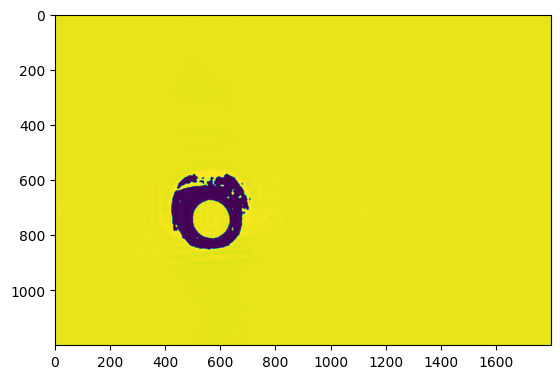

In [132]:
import matplotlib.pyplot as plt
# Select the first mask and display it
plt.imshow(masks[0, 0].astype(np.uint8))